In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

### **Data**

In [ ]:
class Data:
    def __init__(self, path):
        self.path = path
        self.X_train = None
        self.y_train = None
        self.X_test = None
        self.y_test = None

    def display(self):
        df = pd.read_csv(self.path)
        print(df.info())

    def LoadProcess(self):
        # Load data from CSV file
        df = pd.read_csv(self.path)
        df['diagnosis'] = df['diagnosis'].replace('M', 1)
        df['diagnosis'] = df['diagnosis'].replace("B", 0)

        # Assume that the last column is the target variable
        X = df.drop(columns=['id', 'diagnosis'])
        y = df['diagnosis']

        # Standardize the features
        scaler = StandardScaler()
        X = scaler.fit_transform(X)

        # Convert NumPy arrays to PyTorch tensors
        X_tensor = torch.FloatTensor(X)
        y_tensor = torch.LongTensor(y)  # Use LongTensor for classification

         # Split the data into training and testing sets
        self.X_train, X_temp, self.y_train, y_temp = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)
        print("X_train:", len(self.X_train))
        print("X_temp (initial test set):", len(X_temp))

        # Split the initial test set into test and validation sets
        self.X_test, self.X_val, self.y_test, self.y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
        print("X_test:", len(self.X_test))
        print("X_val:", len(self.X_val))


dataset_class = Data('/content/drive/MyDrive/breast-cancer.csv')
dataset_class.display()
dataset_class.LoadProcess()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

# **implementation of MLP network from scratch On validation Set**

First validation (hidden_dims = [10, 5],num_epochs=5000,lr=0.01)

Epoch 1000/5000], Train Loss: 0.5528, Train Accuracy: 0.7868, Val Accuracy: 0.8421
Epoch 2000/5000], Train Loss: 0.4983, Train Accuracy: 0.8374, Val Accuracy: 0.8772
Epoch 3000/5000], Train Loss: 0.4671, Train Accuracy: 0.8593, Val Accuracy: 0.8772
Epoch 4000/5000], Train Loss: 0.4165, Train Accuracy: 0.9055, Val Accuracy: 0.9123
Epoch 5000/5000], Train Loss: 0.3999, Train Accuracy: 0.9187, Val Accuracy: 0.9123
Final Train Accuracy: 0.9187


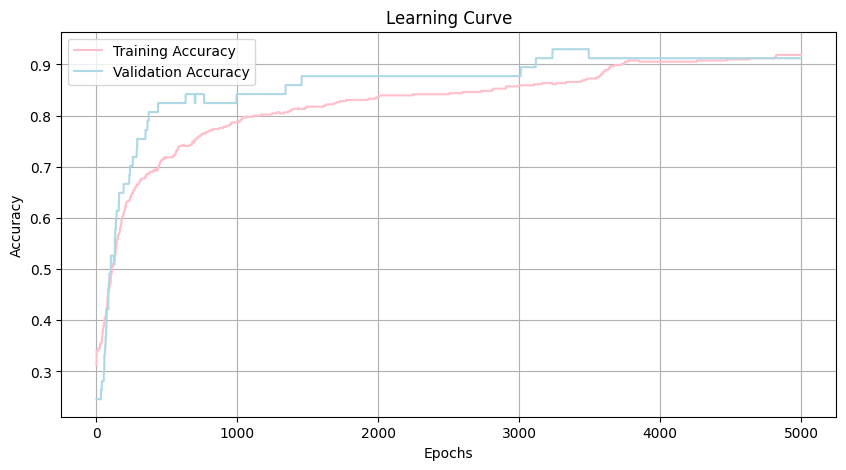

Test Accuracy: 0.9123


In [ ]:
import matplotlib.pyplot as plt

class LinearClassification:
    def __init__(self, input_dim, hidden_dims, output_dim, seed=500):
        torch.manual_seed(seed)

        self.weights_input_to_hidden1 = torch.randn(input_dim, hidden_dims[0], requires_grad=True)
        self.bias_hidden1 = torch.zeros(hidden_dims[0], requires_grad=True)

        self.weights_hidden1_to_hidden2 = torch.randn(hidden_dims[0], hidden_dims[1], requires_grad=True)
        self.bias_hidden2 = torch.zeros(hidden_dims[1], requires_grad=True)

        self.weights_hidden_to_output = torch.randn(hidden_dims[1], output_dim, requires_grad=True)
        self.bias_output = torch.zeros(output_dim, requires_grad=True)

        self.Parameters = [self.weights_input_to_hidden1, self.bias_hidden1,
                           self.weights_hidden1_to_hidden2, self.bias_hidden2,
                           self.weights_hidden_to_output, self.bias_output]

    def softmax(self, logits):
        exp_logits = torch.exp(logits)
        sum_exp_logits = torch.sum(exp_logits, dim=1, keepdim=True)
        return exp_logits / sum_exp_logits

    def relu(self, x):
        return torch.max(torch.zeros_like(x), x)

    def cross_entropy_loss(self, y_true, y_pred):
        y_true = y_true.long()

        log_probs = torch.log(self.softmax(y_pred))
        true_class_log_probs = log_probs.gather(1, y_true.view(-1, 1))
        loss = -true_class_log_probs.mean()

        pred_labels = torch.argmax(y_pred, dim=1)

        return loss, pred_labels

    def Forward_propagation(self, X):
        h1 = self.relu(X @ self.weights_input_to_hidden1 + self.bias_hidden1)
        h2 = self.relu(h1 @ self.weights_hidden1_to_hidden2 + self.bias_hidden2)
        return self.softmax(h2 @ self.weights_hidden_to_output + self.bias_output)

    def Backward_propagation(self, X, y, lr=0.01):
        pred = self.Forward_propagation(X)
        loss, pred_labels = self.cross_entropy_loss(y.long(), pred)
        loss.backward()

        with torch.no_grad():
            for param in self.Parameters:
                param -= lr * param.grad

                param.grad.zero_()

        return loss.item(), pred_labels

    def train(self, X_train, y_train, X_test, y_test, num_epochs=5000):
        train_losses = []
        train_accuracies = []
        val_accuracies = []

        for epoch in range(num_epochs):
            train_loss, pred_labels = self.Backward_propagation(X_train, y_train)
            _, val_pred_labels = self.cross_entropy_loss(y_test.long(), self.Forward_propagation(X_test))

            train_accuracy = accuracy_score(y_train.numpy(), pred_labels.numpy())
            val_accuracy = accuracy_score(y_test.numpy(), val_pred_labels.numpy())

            train_losses.append(train_loss)
            train_accuracies.append(train_accuracy)
            val_accuracies.append(val_accuracy)

            if (epoch + 1) % 1000 == 0:
                print(f'Epoch {epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}')
        # Print the final train accuracy
        final_train_accuracy = train_accuracies[-1]
        print(f'Final Train Accuracy: {final_train_accuracy:.4f}')

        #learning curve
        plt.figure(figsize=(10, 5))
        plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy', color='pink')
        plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', color='lightblue')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title('Learning Curve')
        plt.legend()
        plt.grid(True)
        plt.show()

    def test(self, X_test, y_test):
        predictions = self.Forward_propagation(X_test)
        loss, pred_labels = self.cross_entropy_loss(y_test, predictions)
        accuracy = accuracy_score(y_test.numpy(), pred_labels.numpy())
        return accuracy

input_dim = dataset_class.X_train.shape[1]
output_dim = 2
hidden_dims = [10, 5]
model = LinearClassification(input_dim, hidden_dims, output_dim)

model.train(dataset_class.X_train, dataset_class.y_train, dataset_class.X_val, dataset_class.y_val)
test_accuracy = model.test(dataset_class.X_val, dataset_class.y_val)
print(f'Test Accuracy: {test_accuracy:.4f}')


Second validation (hidden_dims = [10, 5],num_epochs=500,lr=0.0001)

In [ ]:
from sklearn.metrics import accuracy_score
import numpy as np

class LinearClassification:
    def __init__(self, input_dim, hidden_dims, output_dim, seed=500):
        torch.manual_seed(seed)

        self.weights_input_to_hidden1 = torch.randn(input_dim, hidden_dims[0], requires_grad=True)
        self.bias_hidden1 = torch.zeros(hidden_dims[0], requires_grad=True)

        self.weights_hidden1_to_hidden2 = torch.randn(hidden_dims[0], hidden_dims[1], requires_grad=True)
        self.bias_hidden2 = torch.zeros(hidden_dims[1], requires_grad=True)

        self.weights_hidden_to_output = torch.randn(hidden_dims[1], output_dim, requires_grad=True)
        self.bias_output = torch.zeros(output_dim, requires_grad=True)

        self.Parameters = [self.weights_input_to_hidden1, self.bias_hidden1,
                           self.weights_hidden1_to_hidden2, self.bias_hidden2,
                           self.weights_hidden_to_output, self.bias_output]

    def softmax(self, logits):
        exp_logits = torch.exp(logits)
        sum_exp_logits = torch.sum(exp_logits, dim=1, keepdim=True)
        return exp_logits / sum_exp_logits

    def relu(self, x):
        return torch.max(torch.zeros_like(x), x)

    def cross_entropy_loss(self, y_true, y_pred):
        y_true = y_true.long()

        log_probs = torch.log(self.softmax(y_pred))
        true_class_log_probs = log_probs.gather(1, y_true.view(-1, 1))
        loss = -true_class_log_probs.mean()

        pred_labels = torch.argmax(y_pred, dim=1)

        return loss, pred_labels

    def Forward_propagation(self, X):
        h1 = self.relu(X @ self.weights_input_to_hidden1 + self.bias_hidden1)
        h2 = self.relu(h1 @ self.weights_hidden1_to_hidden2 + self.bias_hidden2)
        return self.softmax(h2 @ self.weights_hidden_to_output + self.bias_output)

    def Backward_propagation(self, X, y, lr=0.0001):
        pred = self.Forward_propagation(X)
        loss, pred_labels = self.cross_entropy_loss(y.long(), pred)
        loss.backward()

        with torch.no_grad():
            for param in self.Parameters:
                param -= lr * param.grad

                param.grad.zero_()

        return loss.item(), pred_labels

    def train(self, X_train, y_train, X_test, y_test, num_epochs=5000):
        train_losses = []
        train_accuracies = []
        val_accuracies = []

        for epoch in range(num_epochs):
            train_loss, pred_labels = self.Backward_propagation(X_train, y_train)
            _, val_pred_labels = self.cross_entropy_loss(y_test.long(), self.Forward_propagation(X_test))

            train_accuracy = accuracy_score(y_train.numpy(), pred_labels.numpy())
            val_accuracy = accuracy_score(y_test.numpy(), val_pred_labels.numpy())

            train_losses.append(train_loss)
            train_accuracies.append(train_accuracy)
            val_accuracies.append(val_accuracy)

            if (epoch + 1) % 1000 == 0:
                print(f'Epoch {epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}')
        # Print the final train accuracy
        final_train_accuracy = train_accuracies[-1]
        print(f'Final Train Accuracy: {final_train_accuracy:.4f}')

    def test(self, X_test, y_test):
        predictions = self.Forward_propagation(X_test)
        loss, pred_labels = self.cross_entropy_loss(y_test, predictions)
        accuracy = accuracy_score(y_test.numpy(), pred_labels.numpy())
        return accuracy

input_dim = dataset_class.X_train.shape[1]
output_dim = 2
hidden_dims = [10, 5]
model = LinearClassification(input_dim, hidden_dims, output_dim)

model.train(dataset_class.X_train, dataset_class.y_train, dataset_class.X_val, dataset_class.y_val)
test_accuracy = model.test(dataset_class.X_val, dataset_class.y_val)
print(f'Test Accuracy: {test_accuracy:.4f}')


Epoch 1000/5000], Train Loss: 0.9478, Train Accuracy: 0.3407, Val Accuracy: 0.2456
Epoch 2000/5000], Train Loss: 0.9412, Train Accuracy: 0.3451, Val Accuracy: 0.2456
Epoch 3000/5000], Train Loss: 0.9326, Train Accuracy: 0.3538, Val Accuracy: 0.2456
Epoch 4000/5000], Train Loss: 0.9200, Train Accuracy: 0.3648, Val Accuracy: 0.2807
Epoch 5000/5000], Train Loss: 0.9047, Train Accuracy: 0.3890, Val Accuracy: 0.2807
Final Train Accuracy: 0.3890
Test Accuracy: 0.2807


Third validation (hidden_dims = [10,5, 2],num_epochs=5000,lr=0.001)

In [ ]:
import torch
import torch.nn.functional as F
from sklearn.metrics import accuracy_score

class LinearClassification:
    def __init__(self, input_dim, hidden_dims, output_dim, seed=500):
        torch.manual_seed(seed)

        # Initialize weights and biases for the layers
        self.weights_input_to_hidden1 = torch.randn(input_dim, hidden_dims[0], requires_grad=True)
        self.bias_hidden1 = torch.zeros(hidden_dims[0], requires_grad=True)

        self.weights_hidden1_to_hidden2 = torch.randn(hidden_dims[0], hidden_dims[1], requires_grad=True)
        self.bias_hidden2 = torch.zeros(hidden_dims[1], requires_grad=True)

        self.weights_hidden2_to_hidden3 = torch.randn(hidden_dims[1], hidden_dims[2], requires_grad=True)
        self.bias_hidden3 = torch.zeros(hidden_dims[2], requires_grad=True)

        self.weights_hidden_to_output = torch.randn(hidden_dims[2], output_dim, requires_grad=True)
        self.bias_output = torch.zeros(output_dim, requires_grad=True)

        self.Parameters = [
            self.weights_input_to_hidden1, self.bias_hidden1,
            self.weights_hidden1_to_hidden2, self.bias_hidden2,
            self.weights_hidden2_to_hidden3, self.bias_hidden3,
            self.weights_hidden_to_output, self.bias_output
        ]

    def softmax(self, logits):
        exp_logits = torch.exp(logits)
        sum_exp_logits = torch.sum(exp_logits, dim=1, keepdim=True)
        return exp_logits / sum_exp_logits

    def relu(self, x):
        return torch.max(torch.zeros_like(x), x)

    def cross_entropy_loss(self, y_true, y_pred):
        y_true = y_true.long()
        log_probs = torch.log(self.softmax(y_pred))
        true_class_log_probs = log_probs.gather(1, y_true.view(-1, 1))
        loss = -true_class_log_probs.mean()
        pred_labels = torch.argmax(y_pred, dim=1)
        return loss, pred_labels

    def Forward_propagation(self, X):
        h1 = self.relu(X @ self.weights_input_to_hidden1 + self.bias_hidden1)
        h2 = self.relu(h1 @ self.weights_hidden1_to_hidden2 + self.bias_hidden2)
        h3 = self.relu(h2 @ self.weights_hidden2_to_hidden3 + self.bias_hidden3)
        return self.softmax(h3 @ self.weights_hidden_to_output + self.bias_output)

    def Backward_propagation(self, X, y, lr=0.001):
        pred = self.Forward_propagation(X)
        loss, pred_labels = self.cross_entropy_loss(y.long(), pred)
        loss.backward()

        with torch.no_grad():
            for param in self.Parameters:
                param -= lr * param.grad
                param.grad.zero_()

        return loss.item(), pred_labels

    def train(self, X_train, y_train, X_test, y_test, num_epochs=5000):
        train_losses = []
        train_accuracies = []
        val_accuracies = []

        for epoch in range(num_epochs):
            train_loss, pred_labels = self.Backward_propagation(X_train, y_train)
            _, val_pred_labels = self.cross_entropy_loss(y_test.long(), self.Forward_propagation(X_test))

            train_accuracy = accuracy_score(y_train.numpy(), pred_labels.numpy())
            val_accuracy = accuracy_score(y_test.numpy(), val_pred_labels.numpy())

            train_losses.append(train_loss)
            train_accuracies.append(train_accuracy)
            val_accuracies.append(val_accuracy)

            if (epoch + 1) % 1000 == 0:
                print(f'Epoch {epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}')
        # Print the final train accuracy
        final_train_accuracy = train_accuracies[-1]
        print(f'Final Train Accuracy: {final_train_accuracy:.4f}')

    def test(self, X_test, y_test):
        predictions = self.Forward_propagation(X_test)
        loss, pred_labels = self.cross_entropy_loss(y_test, predictions)
        accuracy = accuracy_score(y_test.numpy(), pred_labels.numpy())
        return accuracy

input_dim = dataset_class.X_train.shape[1]
output_dim = 2
hidden_dims = [10, 5, 15]
model = LinearClassification(input_dim, hidden_dims, output_dim)

model.train(dataset_class.X_train, dataset_class.y_train, dataset_class.X_val, dataset_class.y_val)
test_accuracy = model.test(dataset_class.X_val, dataset_class.y_val)
print(f'Test Accuracy: {test_accuracy:.4f}')


Epoch 1000/5000], Train Loss: 0.7104, Train Accuracy: 0.6066, Val Accuracy: 0.5614
Epoch 2000/5000], Train Loss: 0.5539, Train Accuracy: 0.7604, Val Accuracy: 0.7895
Epoch 3000/5000], Train Loss: 0.5209, Train Accuracy: 0.7978, Val Accuracy: 0.7895
Epoch 4000/5000], Train Loss: 0.5116, Train Accuracy: 0.8088, Val Accuracy: 0.7895
Epoch 5000/5000], Train Loss: 0.5084, Train Accuracy: 0.8088, Val Accuracy: 0.7895
Final Train Accuracy: 0.8088
Test Accuracy: 0.7895


Fourth validation (hidden_dims = [10, 5, 15],num_epochs=500,lr=0.0001)

In [ ]:
import torch
import torch.nn.functional as F
from sklearn.metrics import accuracy_score

class LinearClassification:
    def __init__(self, input_dim, hidden_dims, output_dim, seed=500):
        torch.manual_seed(seed)

        # Initialize weights and biases for the layers
        self.weights_input_to_hidden1 = torch.randn(input_dim, hidden_dims[0], requires_grad=True)
        self.bias_hidden1 = torch.zeros(hidden_dims[0], requires_grad=True)

        self.weights_hidden1_to_hidden2 = torch.randn(hidden_dims[0], hidden_dims[1], requires_grad=True)
        self.bias_hidden2 = torch.zeros(hidden_dims[1], requires_grad=True)

        self.weights_hidden2_to_hidden3 = torch.randn(hidden_dims[1], hidden_dims[2], requires_grad=True)
        self.bias_hidden3 = torch.zeros(hidden_dims[2], requires_grad=True)

        self.weights_hidden_to_output = torch.randn(hidden_dims[2], output_dim, requires_grad=True)
        self.bias_output = torch.zeros(output_dim, requires_grad=True)

        self.Parameters = [
            self.weights_input_to_hidden1, self.bias_hidden1,
            self.weights_hidden1_to_hidden2, self.bias_hidden2,
            self.weights_hidden2_to_hidden3, self.bias_hidden3,
            self.weights_hidden_to_output, self.bias_output
        ]

    def softmax(self, logits):
        exp_logits = torch.exp(logits)
        sum_exp_logits = torch.sum(exp_logits, dim=1, keepdim=True)
        return exp_logits / sum_exp_logits

    def relu(self, x):
        return torch.max(torch.zeros_like(x), x)

    def cross_entropy_loss(self, y_true, y_pred):
        y_true = y_true.long()
        log_probs = torch.log(self.softmax(y_pred))
        true_class_log_probs = log_probs.gather(1, y_true.view(-1, 1))
        loss = -true_class_log_probs.mean()
        pred_labels = torch.argmax(y_pred, dim=1)
        return loss, pred_labels

    def Forward_propagation(self, X):
        h1 = self.relu(X @ self.weights_input_to_hidden1 + self.bias_hidden1)
        h2 = self.relu(h1 @ self.weights_hidden1_to_hidden2 + self.bias_hidden2)
        h3 = self.relu(h2 @ self.weights_hidden2_to_hidden3 + self.bias_hidden3)
        return self.softmax(h3 @ self.weights_hidden_to_output + self.bias_output)

    def Backward_propagation(self, X, y, lr=0.0001):
        pred = self.Forward_propagation(X)
        loss, pred_labels = self.cross_entropy_loss(y.long(), pred)
        loss.backward()

        with torch.no_grad():
            for param in self.Parameters:
                param -= lr * param.grad
                param.grad.zero_()

        return loss.item(), pred_labels

    def train(self, X_train, y_train, X_test, y_test, num_epochs=5000):
        train_losses = []
        train_accuracies = []
        val_accuracies = []

        for epoch in range(num_epochs):
            train_loss, pred_labels = self.Backward_propagation(X_train, y_train)
            _, val_pred_labels = self.cross_entropy_loss(y_test.long(), self.Forward_propagation(X_test))

            train_accuracy = accuracy_score(y_train.numpy(), pred_labels.numpy())
            val_accuracy = accuracy_score(y_test.numpy(), val_pred_labels.numpy())

            train_losses.append(train_loss)
            train_accuracies.append(train_accuracy)
            val_accuracies.append(val_accuracy)

            if (epoch + 1) % 1000 == 0:
                print(f'Epoch {epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}')
        # Print the final train accuracy
        final_train_accuracy = train_accuracies[-1]
        print(f'Final Train Accuracy: {final_train_accuracy:.4f}')

    def test(self, X_test, y_test):
        predictions = self.Forward_propagation(X_test)
        loss, pred_labels = self.cross_entropy_loss(y_test, predictions)
        accuracy = accuracy_score(y_test.numpy(), pred_labels.numpy())
        return accuracy

input_dim = dataset_class.X_train.shape[1]
output_dim = 2
hidden_dims = [10, 5, 15]
model = LinearClassification(input_dim, hidden_dims, output_dim)

model.train(dataset_class.X_train, dataset_class.y_train, dataset_class.X_val, dataset_class.y_val)
test_accuracy = model.test(dataset_class.X_val, dataset_class.y_val)
print(f'Test Accuracy: {test_accuracy:.4f}')

Epoch 1000/5000], Train Loss: 0.7960, Train Accuracy: 0.5209, Val Accuracy: 0.4211
Epoch 2000/5000], Train Loss: 0.7883, Train Accuracy: 0.5297, Val Accuracy: 0.4211
Epoch 3000/5000], Train Loss: 0.7777, Train Accuracy: 0.5429, Val Accuracy: 0.4386
Epoch 4000/5000], Train Loss: 0.7678, Train Accuracy: 0.5538, Val Accuracy: 0.4561
Epoch 5000/5000], Train Loss: 0.7593, Train Accuracy: 0.5604, Val Accuracy: 0.4737
Final Train Accuracy: 0.5604
Test Accuracy: 0.4737


Fifth validation (hidden_dims = [5,5,5,5],num_epochs=5000,lr=0.001)

In [ ]:
import torch
import torch.nn.functional as F
from sklearn.metrics import accuracy_score

class LinearClassification:
    def __init__(self, input_dim, hidden_dims, output_dim, seed=500):
        torch.manual_seed(seed)

        # Initialize weights and biases for the layers
        self.weights_input_to_hidden1 = torch.randn(input_dim, hidden_dims[0], requires_grad=True)
        self.bias_hidden1 = torch.zeros(hidden_dims[0], requires_grad=True)

        self.weights_hidden1_to_hidden2 = torch.randn(hidden_dims[0], hidden_dims[1], requires_grad=True)
        self.bias_hidden2 = torch.zeros(hidden_dims[1], requires_grad=True)

        self.weights_hidden2_to_hidden3 = torch.randn(hidden_dims[1], hidden_dims[2], requires_grad=True)
        self.bias_hidden3 = torch.zeros(hidden_dims[2], requires_grad=True)

        self.weights_hidden3_to_hidden4 = torch.randn(hidden_dims[2], hidden_dims[3], requires_grad=True)
        self.bias_hidden4 = torch.zeros(hidden_dims[3], requires_grad=True)

        self.weights_hidden_to_output = torch.randn(hidden_dims[3], output_dim, requires_grad=True)
        self.bias_output = torch.zeros(output_dim, requires_grad=True)

        self.Parameters = [
            self.weights_input_to_hidden1, self.bias_hidden1,
            self.weights_hidden1_to_hidden2, self.bias_hidden2,
            self.weights_hidden2_to_hidden3, self.bias_hidden3,
            self.weights_hidden3_to_hidden4, self.bias_hidden4,
            self.weights_hidden_to_output, self.bias_output
        ]

    def softmax(self, logits):
        exp_logits = torch.exp(logits)
        sum_exp_logits = torch.sum(exp_logits, dim=1, keepdim=True)
        return exp_logits / sum_exp_logits

    def relu(self, x):
        return torch.max(torch.zeros_like(x), x)

    def cross_entropy_loss(self, y_true, y_pred):
        y_true = y_true.long()
        log_probs = torch.log(self.softmax(y_pred))
        true_class_log_probs = log_probs.gather(1, y_true.view(-1, 1))
        loss = -true_class_log_probs.mean()
        pred_labels = torch.argmax(y_pred, dim=1)
        return loss, pred_labels

    def Forward_propagation(self, X):
        h1 = self.relu(X @ self.weights_input_to_hidden1 + self.bias_hidden1)
        h2 = self.relu(h1 @ self.weights_hidden1_to_hidden2 + self.bias_hidden2)
        h3 = self.relu(h2 @ self.weights_hidden2_to_hidden3 + self.bias_hidden3)
        h4 = self.relu(h3 @ self.weights_hidden3_to_hidden4 + self.bias_hidden4)
        return self.softmax(h4 @ self.weights_hidden_to_output + self.bias_output)

    def Backward_propagation(self, X, y, lr=0.001):
        pred = self.Forward_propagation(X)
        loss, pred_labels = self.cross_entropy_loss(y.long(), pred)
        loss.backward()

        with torch.no_grad():
            for param in self.Parameters:
                param -= lr * param.grad
                param.grad.zero_()

        return loss.item(), pred_labels

    def train(self, X_train, y_train, X_test, y_test, num_epochs=5000):
        train_losses = []
        train_accuracies = []
        val_accuracies = []

        for epoch in range(num_epochs):
            train_loss, pred_labels = self.Backward_propagation(X_train, y_train)
            _, val_pred_labels = self.cross_entropy_loss(y_test.long(), self.Forward_propagation(X_test))

            train_accuracy = accuracy_score(y_train.numpy(), pred_labels.numpy())
            val_accuracy = accuracy_score(y_test.numpy(), val_pred_labels.numpy())

            train_losses.append(train_loss)
            train_accuracies.append(train_accuracy)
            val_accuracies.append(val_accuracy)

            if (epoch + 1) % 1000 == 0:
                print(f'Epoch {epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}')
        # Print the final train accuracy
        final_train_accuracy = train_accuracies[-1]
        print(f'Final Train Accuracy: {final_train_accuracy:.4f}')

    def test(self, X_test, y_test):
        predictions = self.Forward_propagation(X_test)
        loss, pred_labels = self.cross_entropy_loss(y_test, predictions)
        accuracy = accuracy_score(y_test.numpy(), pred_labels.numpy())
        return accuracy

input_dim = dataset_class.X_train.shape[1]
output_dim = 2
hidden_dims = [5, 5, 5,5]
model = LinearClassification(input_dim, hidden_dims, output_dim)

model.train(dataset_class.X_train, dataset_class.y_train, dataset_class.X_val, dataset_class.y_val)
test_accuracy = model.test(dataset_class.X_val, dataset_class.y_val)
print(f'Test Accuracy: {test_accuracy:.4f}')

Epoch 1000/5000], Train Loss: 0.5777, Train Accuracy: 0.8176, Val Accuracy: 0.9123
Epoch 2000/5000], Train Loss: 0.5306, Train Accuracy: 0.8242, Val Accuracy: 0.8947
Epoch 3000/5000], Train Loss: 0.5000, Train Accuracy: 0.8549, Val Accuracy: 0.9123
Epoch 4000/5000], Train Loss: 0.4793, Train Accuracy: 0.8747, Val Accuracy: 0.9123
Epoch 5000/5000], Train Loss: 0.4663, Train Accuracy: 0.8769, Val Accuracy: 0.9123
Final Train Accuracy: 0.8769
Test Accuracy: 0.9123


# **implementation of MLP network from scratch On test Set**

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

class LinearClassification:
    def __init__(self, input_dim, hidden_dims, output_dim, seed=500):
        torch.manual_seed(seed)

        self.weights_input_to_hidden1 = torch.randn(input_dim, hidden_dims[0], requires_grad=True)
        self.bias_hidden1 = torch.zeros(hidden_dims[0], requires_grad=True)

        self.weights_hidden1_to_hidden2 = torch.randn(hidden_dims[0], hidden_dims[1], requires_grad=True)
        self.bias_hidden2 = torch.zeros(hidden_dims[1], requires_grad=True)

        self.weights_hidden_to_output = torch.randn(hidden_dims[1], output_dim, requires_grad=True)
        self.bias_output = torch.zeros(output_dim, requires_grad=True)

        self.Parameters = [self.weights_input_to_hidden1, self.bias_hidden1,
                           self.weights_hidden1_to_hidden2, self.bias_hidden2,
                           self.weights_hidden_to_output, self.bias_output]

    def softmax(self, logits):
        exp_logits = torch.exp(logits)
        sum_exp_logits = torch.sum(exp_logits, dim=1, keepdim=True)
        return exp_logits / sum_exp_logits

    def relu(self, x):
        return torch.max(torch.zeros_like(x), x)

    def cross_entropy_loss(self, y_true, y_pred):
        y_true = y_true.long()

        log_probs = torch.log(self.softmax(y_pred))
        true_class_log_probs = log_probs.gather(1, y_true.view(-1, 1))
        loss = -true_class_log_probs.mean()

        pred_labels = torch.argmax(y_pred, dim=1)

        return loss, pred_labels

    def Forward_propagation(self, X):
        h1 = self.relu(X @ self.weights_input_to_hidden1 + self.bias_hidden1)
        h2 = self.relu(h1 @ self.weights_hidden1_to_hidden2 + self.bias_hidden2)
        return self.softmax(h2 @ self.weights_hidden_to_output + self.bias_output)

    def Backward_propagation(self, X, y, lr=0.01):
        pred = self.Forward_propagation(X)
        loss, pred_labels = self.cross_entropy_loss(y.long(), pred)
        loss.backward()

        with torch.no_grad():
            for param in self.Parameters:
                param -= lr * param.grad

                # Zero gradients after update
                param.grad.zero_()

        return loss.item(), pred_labels

    def train(self,X_test, y_test, X_val, y_val, num_epochs=5000):
      self.true_labels = y_val
      for epoch in range(num_epochs):
        train_loss, pred_labels = self.Backward_propagation(X_test, y_test)
        test_predictions = self.Forward_propagation(X_val)
        _, test_pred_labels = self.cross_entropy_loss(y_val.long(), test_predictions)

        train_accuracy = accuracy_score(y_test.numpy(), pred_labels.numpy())
        test_accuracy = accuracy_score(y_val.numpy(), test_pred_labels.numpy())

        self.final_pred_labels = test_pred_labels

        if (epoch + 1) % 1000 == 0:
          print(f'Epoch {epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}')

    def test(self, X_val, y_val):
        predictions = self.Forward_propagation(X_val)
        loss, pred_labels = self.cross_entropy_loss(y_val, predictions)
        self.final_pred_labels = pred_labels
        accuracy = accuracy_score(y_val.numpy(), pred_labels.numpy())
        return accuracy

input_dim = dataset_class.X_train.shape[1]
output_dim = 2
hidden_dims = [10, 5]
model = LinearClassification(input_dim, hidden_dims, output_dim)

model.train(dataset_class.X_train, dataset_class.y_train, dataset_class.X_test, dataset_class.y_test)
test_accuracy = model.test(dataset_class.X_test, dataset_class.y_test)
print(f'Test Accuracy: {test_accuracy:.4f}')

conf_matrix = confusion_matrix(model.true_labels.numpy(), model.final_pred_labels.numpy())

Epoch 1000/5000], Train Loss: 0.5528, Train Accuracy: 0.7868, Test Accuracy: 0.7193
Epoch 2000/5000], Train Loss: 0.4983, Train Accuracy: 0.8374, Test Accuracy: 0.8246
Epoch 3000/5000], Train Loss: 0.4671, Train Accuracy: 0.8593, Test Accuracy: 0.8421
Epoch 4000/5000], Train Loss: 0.4165, Train Accuracy: 0.9055, Test Accuracy: 0.8947
Epoch 5000/5000], Train Loss: 0.3999, Train Accuracy: 0.9187, Test Accuracy: 0.8947
Test Accuracy: 0.8947


In [ ]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score
precision = precision_score(model.true_labels.numpy(), model.final_pred_labels.numpy())
recall = recall_score(model.true_labels.numpy(), model.final_pred_labels.numpy())
f1 = f1_score(model.true_labels.numpy(), model.final_pred_labels.numpy())
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')


Precision: 0.9200
Recall: 0.8519
F1-score: 0.8846


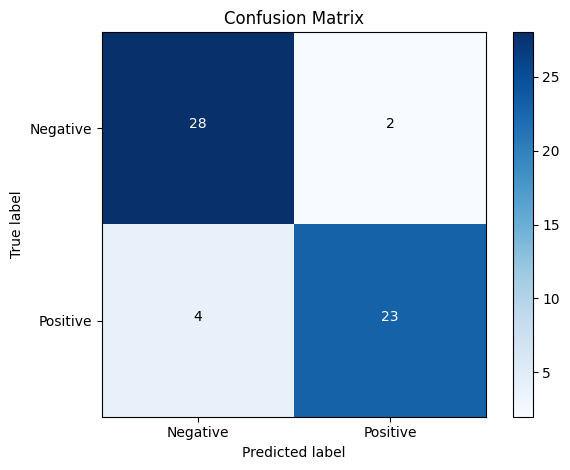

In [ ]:
# confusion matrix
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

#labels
classes = ['Negative', 'Positive']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

#text annotations
thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()

# **implementation of MLP network using NN**

In [ ]:
# SimpleNN class
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size_1, hidden_size_2, output_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size_1)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size_1, hidden_size_2)
        self.relu = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size_2, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x


input_size = dataset_class.X_train.shape[1]
hidden_size_1 = 10
hidden_size_2 = 5
output_size = 1

simple_nn_model = SimpleNN(input_size, hidden_size_1, hidden_size_2, output_size)
num_epochs = 5000
optimizer_simple_nn = optim.Adam(simple_nn_model.parameters(), lr=0.01)
criterion_simple_nn = nn.BCELoss()

# Reshape
y_train = dataset_class.y_train.view(-1, 1)
y_test = dataset_class.y_test.view(-1, 1)

# Training
print("\nTraining Simple Neural Network:")
for epoch in range(num_epochs):
    simple_nn_model.train()
    optimizer_simple_nn.zero_grad()
    outputs = simple_nn_model(dataset_class.X_train)
    loss = criterion_simple_nn(outputs, y_train.float())
    loss.backward()
    optimizer_simple_nn.step()

# Evaluate
simple_nn_model.eval()
with torch.no_grad():
    outputs_test = simple_nn_model(dataset_class.X_test)
    preds_test = (outputs_test > 0.5).float()
    nn_accuracy_test = accuracy_score(dataset_class.y_test.numpy(), preds_test.numpy())
    nn_precision_test = precision_score(dataset_class.y_test.numpy(), preds_test.numpy())
    nn_recall_test = recall_score(dataset_class.y_test.numpy(), preds_test.numpy())
    nn_f1_test = f1_score(dataset_class.y_test.numpy(), preds_test.numpy())

print(f"Accuracy of the Simple Neural Network on the test data: {nn_accuracy_test:.4f}")
print(f"Precision of the Simple Neural Network on the test data: {nn_precision_test:.4f}")
print(f"Recall of the Simple Neural Network on the test data: {nn_recall_test:.4f}")
print(f"F1-Score of the Simple Neural Network on the test data: {nn_f1_test:.4f}")


Training Simple Neural Network:
Accuracy of the Simple Neural Network on the test data: 0.9649
Precision of the Simple Neural Network on the test data: 1.0000
Recall of the Simple Neural Network on the test data: 0.9259
F1-Score of the Simple Neural Network on the test data: 0.9615
